# Import and Set Paths

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import statistics 
from scipy.stats import skew
import numpy as np
import pandas as pd
from google.oauth2 import service_account #Control API Keys
from google.cloud import vision
from pdf2image import convert_from_path #Libary convert pdf file to img file
import os
import cv2
from google.cloud import language_v1
from google.cloud.language_v1 import enums
from collections import Counter
import io
import random
from random import randrange
from IPython.display import Image
from shapely.geometry import Polygon
#import argparse
from enum import Enum
import io
from google.cloud.vision import types
from PIL import Image, ImageDraw
from PIL import ImageFont
from pyresparser import ResumeParser
import shutil
from shutil import copyfile
import random
import string
import spacy
from pandas import ExcelWriter
from termcolor import colored
from stop_words import get_stop_words
stop_words = get_stop_words('english')
nlp = spacy.load("en_core_web_sm")

## Paths

In [3]:
#doc = '/Users/kunal/Documents/VdartResumeProject/VisionAPi/Document_402.pdf'
docPath = '/Users/kunal/Documents/VdartResumeProject/VisionAPi/'
imgTxtVisionAPIPath = "/Users/kunal/Documents/VdartResumeProject/APIKEYSGOOGLE/resumeMatcher-pdf2img.json"
pdfIMGPopplerPath = '/Users/kunal/Documents/VdartResumeProject/Poppler/poppler-0.68.0_x86/poppler-0.68.0/bin/'
fontPath = '/Users/kunal/Documents/VdartResumeProject/Font/FreeMonoBold.ttf'
allResumesPath = "/Users/kunal/Documents/VdartResumeProject/50_resumes/"
nlpAutoAPIPath = "/Users/kunal/Documents/VdartResumeProject/APIKEYSGOOGLE/resumeMatcher-NLP_create_data.json"

## Setting info about API

In [4]:
#Using API from Google
#Returns a JSON file but text is extracted from it
keyDIR = imgTxtVisionAPIPath #JSON key file to call the api
credentials = service_account.Credentials.from_service_account_file(keyDIR) #using service account to go through google
client = vision.ImageAnnotatorClient(credentials=credentials) # client api

## Acutal Image Path

In [141]:
imagePath = '/Users/kunal/Documents/VdartResumeProject/VisionAPi/Fold_Document_1504/Document_1504_1.jpg'

## Thresholds

In [142]:
"""THRESHOLDFORWORD = 70
THRESHOLDFORPARA = 70
CUTOFWORDSTHATARE3ORUNDER = True
MAXIMUMLENGTHOFWORDSPARA = 20
TOTALSUMFINALPARATHRESHOLD = 50
THRESHOLDSYMBOLMEANTESTWORD = 80
THRESHOLDPARAGROUPSYMWORD = 40"""
THRESHOLDFORWORD = 70
THRESHOLDFORPARA = 70
CUTOFWORDSTHATARE3ORUNDER = True
MAXIMUMLENGTHOFWORDSPARA = 20
TOTALSUMFINALPARATHRESHOLD = 50
THRESHOLDSYMBOLMEANTESTWORD = 80
THRESHOLDPARAGROUPSYMWORD = 40

# Display Document Img

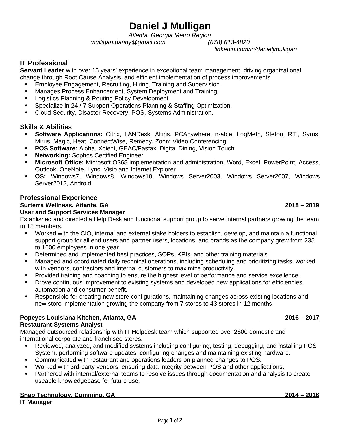

In [143]:
img = Image.open(imagePath)
display(img.resize((int(img.size[0]/5),int(img.size[1]/5)), 0))
#display(img.resize((int(img.size[0]/2),int(img.size[1]/2)), 0))

## Get base information

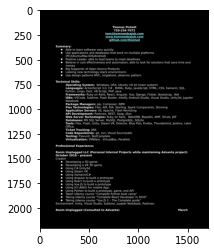

(2200, 1700, 3)


In [8]:
my_img = cv2.imread(imagePath) 
inverted_img = (255.0 - my_img)  
final = inverted_img / 255.0
# Visualize the result
plt.imshow(final)
plt.show()
print(final.shape)

# Call API

In [9]:
print(imagePath)

/Users/kunal/Documents/VdartResumeProject/VisionAPi/Fold_Document_406/Document_406_1.jpg


In [10]:
keyDIR = imgTxtVisionAPIPath #JSON key file to call the api
credentials = service_account.Credentials.from_service_account_file(keyDIR) #using service account to go through google
client = vision.ImageAnnotatorClient(credentials=credentials) # client api
bounds = []
with io.open(imagePath, 'rb') as image_file:
    content = image_file.read()
image = types.Image(content=content)
response = client.document_text_detection(image=image)
global document
document = response.full_text_annotation

## W/H of document|

In [11]:
global TOTALWIDTHOFDOCUMENT
global TOTALHEIGHTOFDOCUMENT
response4 = client.document_text_detection(image = image)
for i in response4.full_text_annotation.pages:
    TOTALWIDTHOFDOCUMENT = i.width
    TOTALHEIGHTOFDOCUMENT = i.height

# Base Functions

In [12]:
def findArea(bounds):
    matrix = ((bounds.vertices[0].x, bounds.vertices[0].y),
              (bounds.vertices[1].x, bounds.vertices[1].y),
              (bounds.vertices[2].x, bounds.vertices[2].y),
              (bounds.vertices[3].x, bounds.vertices[3].y))    
    polygon = Polygon(matrix)
    return polygon.area

In [13]:
def detect_Maximum_outlier(data_1):
    #z = (X — μ) / σ
    #Formula for Z score = (Observation — Mean)/Standard Deviation
    outliers=[]
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold and y > mean_1:
            outliers.append(y)
    return outliers
def findMaxOutliersIQR(datasetInput):
    dataset = sorted(datasetInput)
    q1, q3= np.percentile(dataset,[25,75])
    iqr = q3 - q1
    upper_bound = q3 +(1.5 * iqr) 
    outliers=[]
    for num in dataset:
        if num>upper_bound:
            outliers.append(num)
    return outliers
def averageOfBothOutliers(data):
    return (min(detect_Maximum_outlier(data)) + min(findMaxOutliersIQR(data)))/2

# Erosion

## Get number of each character in document

In [14]:
alphaList = list(string.ascii_lowercase) + list(string.ascii_uppercase)

In [15]:
allbbChar = []
for charater in alphaList:
    charbb = []
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    for symbol in word.symbols:
                        if symbol.text == charater:
                            charbb.append(symbol.bounding_box)
    allbbChar.append(charbb)

In [16]:
dfList = []
for i in range(len(allbbChar)):
    charLen = [alphaList[i], len(allbbChar[i])]
    dfList.append(charLen)
    #print(alphaList[i] + "\t" +  str(len(allbbChar[i])))

In [17]:
df=pd.DataFrame(dfList, columns=['Char','NumberOfChars']) 

In [18]:
print(df)

   Char  NumberOfChars
0     a            110
1     b             29
2     c             41
3     d             42
4     e            168
5     f             11
6     g             45
7     h             21
8     i            107
9     j              6
10    k             19
11    l             70
12    m             47
13    n            111
14    o            127
15    p             50
16    q              1
17    r             81
18    s             83
19    t            126
20    u             53
21    v             20
22    w              9
23    x              7
24    y             27
25    z              2
26    A             18
27    B              9
28    C             17
29    D             12
30    E              4
31    F             13
32    G              0
33    H              2
34    I             10
35    J             10
36    K              0
37    L             14
38    M             12
39    N              4
40    O              7
41    P             21
42    Q    

## Find Mode of Height and Width of each character

In [19]:
def convertBoundBoxtodiagonalRectangual(polygon):
    #print(polygon)
    if (abs(polygon.vertices[0].x - polygon.vertices[3].x)<=1 and 
        abs(polygon.vertices[0].y - polygon.vertices[1].y)<=1 and 
        abs(polygon.vertices[1].x - polygon.vertices[2].x)<=1 and 
        abs(polygon.vertices[2].y - polygon.vertices[3].y)<=1):
        matrixCrop = (min(polygon.vertices[0].x, polygon.vertices[3].x),
                      min(polygon.vertices[0].y, polygon.vertices[1].y),
                      max(polygon.vertices[1].x, polygon.vertices[2].x),
                      max(polygon.vertices[2].y, polygon.vertices[3].y))
    else:
        matrixCrop = (min(polygon.vertices[0].x, polygon.vertices[3].x),
                      min(polygon.vertices[0].y, polygon.vertices[1].y),
                      max(polygon.vertices[1].x, polygon.vertices[2].x),
                      max(polygon.vertices[2].y, polygon.vertices[3].y))
        print("MaybeErrrorWhenConvertingPolygonToRectangle")
        #raise Exception
        #matrixCrop = (0,0,0,0)
    return matrixCrop

In [20]:
def findModeLongWay(lst):
    if len(lst) == 0:
        return 0
    from collections import Counter
    d_mem_count = Counter(lst)
    modeLst = []
    for k in d_mem_count.keys():
        if d_mem_count[k] > 1:
            modeLst.append(k)
    try:
        return int(round(statistics.mean(modeLst)))
    except:
        return 0
    

In [21]:
#print("Height")
#print("Mode " + str(statistics.mode(totalWHAllChar[0][0])))
#print("Mean " + str(statistics.mean(totalWHAllChar[0][0])))
#print("Median " + str(statistics.median(totalWHAllChar[0][0])))
#print("Width")
#print("Mode " + str(statistics.mode(totalWHAllChar[0][1])))
#print("Mean " + str(statistics.mean(totalWHAllChar[0][1])))
#print("Median " + str(statistics.median(totalWHAllChar[0][1])))
#print("Height of the picture --> " + str(len(new_img)))
#print("Width of the picture -->  " + str(len(new_img[0])))

In [22]:
totalWHAllChar = []
for i in range(len(allbbChar)):
    heightChar = []
    widthChar = []
    for singleChar in allbbChar[i]:
        cropPoints = convertBoundBoxtodiagonalRectangual(singleChar)
        im = Image.open(imagePath).convert("RGBA")
        im_crop = im.crop(cropPoints)
        opencvImage = cv2.cvtColor(np.array(im_crop), cv2.COLOR_RGB2BGR)
        img_reverted= cv2.bitwise_not(opencvImage)
        new_img = img_reverted / 255.0 
        heightChar.append(len(new_img))
        widthChar.append(len(new_img[0]))
    #totalWHAllChar.append([heightChar, widthChar])
    try:
        totalWHAllChar.append([statistics.mode(heightChar), statistics.mode(widthChar)])
    except:
        totalWHAllChar.append([findModeLongWay(heightChar), findModeLongWay(widthChar)])

In [23]:
dfListNew = []
#totalWHAllChar
for i in range(len(dfList)):
    dfListNew.append([dfList[i][0], dfList[i][1], totalWHAllChar[i][0], totalWHAllChar[i][1]])

In [24]:
df=pd.DataFrame(dfListNew, columns=['Char','NumberOfChars','ModeHeight', 'ModeWidth']) 

In [25]:
df

,Char,NumberOfChars,ModeHeight,ModeWidth
0,a,110,34,12
1,b,29,33,14
2,c,41,33,10
3,d,42,32,13
4,e,168,32,13
5,f,11,30,8
6,g,45,32,13
7,h,21,33,12
8,i,107,32,2
9,j,6,34,8


## Find Area of each Char

## create all images

### Functions

In [26]:
#plt.figure()
#f, axarr = plt.subplots(1,4) 
#axarr[0].imshow(new_img)
#axarr[1].imshow(croppedTopBottomImg)
#axarr[2].imshow(newImgOnly01)
#axarr[3].imshow(croppedTopBottomImgOnly01)

In [27]:
def cutTopandBottomBlackRowsFunction(new_img):
    # GO THROUGH EACH ROW IN ORGINAL PICTURE AND MARK OUT THE ROWS THAT NEED TO BE DELETED
    deleteRows = []
    rowNum = 0
    for row in new_img:
        ct = 0
        for rgb in row:
            if not all(rgb == 0):
                break
            else:
                ct+=1
        #print(ct==len(row))
        if (ct==len(row)):
            deleteRows.append(rowNum)
        rowNum+=1
    # GO THROUGH EACH ROW AND DELETE THE ROWS -- IMG CROPPED TOP AND BOTTOM
    rowCt = 0
    croppedTopBottomImg = []
    for row in new_img:
        if rowCt not in deleteRows:
            newrow = []
            for rgb in row:
                #print(rgb)
                newrow.append([rgb[0], rgb[1], rgb[2]])
            #print(newrow)
            #print(row)
            #print()
            croppedTopBottomImg.append(newrow)
        #print(rowCt)
        rowCt+=1
    return croppedTopBottomImg

In [28]:
def convertImgto01OrginalFunction(new_img):
    # CONVERT IMAGE TO 0 AND 1 IMAGE FROM THE ORGINAL IMAGE
    newImgOnly01 = []
    for row in new_img:
        newRow = []
        for rgb in row:
            newArrayRowz = []
            for color in rgb:
                if color >= 0.5:
                    newArrayRowz.append(255)
                else:
                    newArrayRowz.append(0)
            newRow.append(newArrayRowz)
        newImgOnly01.append(newRow)
    return newImgOnly01

In [29]:
def cropTopBottomFrom01Img(newImgOnly01):
    # FIND ROWS THAT NEED TO BE DELETED FROM 0 AND 1 IMAGE
    deleteRows = []
    rowNum = 0
    for row in newImgOnly01:
        ct = 0
        #print(row)
        for rgb in row:
            #print(rgb)
            if not rgb == [0,0,0]:
                break
            else:
                ct+=1
        #print(ct==len(row))
        if (ct==len(row)):
            deleteRows.append(rowNum)
        rowNum+=1
    # CREATE NEW IMAGE WITH CROPPED 0 AND 1 IMAGES
    rowCt = 0
    croppedTopBottomImgOnly01 = []
    for row in newImgOnly01:
        if rowCt not in deleteRows:
            croppedTopBottomImgOnly01.append(row)
        #print(rowCt)
        rowCt+=1
    return croppedTopBottomImgOnly01

In [30]:
def percentAreafromImg(img):
    if len(img) == 0:
        return 0
    ctYes = 0
    for row in img:
        for value in row:
            if value != [0,0,0]:
                ctYes+=1
    return round(ctYes/(len(croppedTopBottomImgOnly01)*len(croppedTopBottomImgOnly01[0]))*100,4)

In [31]:
def displayImg(arrayofImgs):
    plt.figure()
    f, axarr = plt.subplots(1,len(display)) 
    for i in range(len(display)):
        axarr[i].imshow(display[i])

## Run to create each Char Pics and Capture data

In [32]:
%%time
templst = []
strokeWidthArray = []
for i in range(len(allbbChar)):
    areaAllForChar = []
    pictureForChar = []
    for singleChar in allbbChar[i]:
        cropPoints = convertBoundBoxtodiagonalRectangual(singleChar)
        im = Image.open(imagePath).convert("RGBA")
        im_crop = im.crop(cropPoints)
        opencvImage = cv2.cvtColor(np.array(im_crop), cv2.COLOR_RGB2BGR)
        img_reverted= cv2.bitwise_not(opencvImage)
        new_img = img_reverted / 255.0 
        #croppedTopBottomImg = cutTopandBottomBlackRowsFunction(new_img)
        newImgOnly01 = convertImgto01OrginalFunction(new_img)
        croppedTopBottomImgOnly01 = cropTopBottomFrom01Img(newImgOnly01)
        #display = [new_img,croppedTopBottomImg, newImgOnly01, croppedTopBottomImgOnly01]
        #displayImg(display)
        percentAreaConverd = percentAreafromImg(croppedTopBottomImgOnly01)
        areaAllForChar.append(percentAreaConverd)
        pictureForChar.append(croppedTopBottomImgOnly01)
    templst.append(areaAllForChar)
    strokeWidthArray.append(pictureForChar)

Wall time: 1min 43s


### Process data for area of each Char

In [33]:
for i in range(len(dfListNew)):
    if not (dfListNew[i][1] == len(templst[i])):
        raise ValueError('The values are not equal')

In [34]:
def findOutlierCutoffIQR(datasetInput):
    dataset = sorted(datasetInput)
    q1, q3= np.percentile(dataset,[25,75])
    iqr = q3 - q1
    return q3 +(1.5 * iqr) 

In [35]:
dfListNew2 = []
for i in range(len(dfListNew)):
    charLstbefore = [dfListNew[i][0], dfListNew[i][1], dfListNew[i][2], dfListNew[i][3]]
    if not len(templst[i]) == 0:
        charLstbefore.append(round(statistics.median(templst[i]),4))
        charLstbefore.append(round(statistics.mean(templst[i]),4))
        try:
            charLstbefore.append(round(statistics.mode(templst[i]),4))
        except:
            charLstbefore.append(round(statistics.median(templst[i]),4))
        charLstbefore.append(round(findOutlierCutoffIQR(templst[i]),4))
        charLstbefore.append(round(len(detect_Maximum_outlier(templst[i])),4))
        charLstbefore.append(round(len(findMaxOutliersIQR(templst[i])),4))
        
    else:
        charLstbefore.extend([0,0,0,0,0,0])
    dfListNew2.append(charLstbefore)

C:\Users\kunal\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


#### Add to DF

In [36]:
colName = ['Char','NumberOfChars','ModeHeight','ModeWidth','MedianArea','MeanArea','ModeArea', 'MaxOutlierNum', 'NumOutlierZScore', 'NumOutlierIQR']
df=pd.DataFrame(dfListNew2, columns=colName) 

In [37]:
FINALALLINFOLIST = dfListNew2

### Process data to find the stoke width

In [38]:
print("There is " + str(len(strokeWidthArray)) + " symbols in the array.\nIts a,b,c,d...x,y,z,A,B,C...X,Y,Z.\nIn each Position is the RGB for that image")
print("Example")
print(strokeWidthArray[0][0][:2])
for i in dfListNew:
    if i[1] < 10:
        print("Char "+ i[0] + " has only " + colored(str(i[1]), 'red', attrs=['bold']))

There is 52 symbols in the array.
Its a,b,c,d...x,y,z,A,B,C...X,Y,Z.
In each Position is the RGB for that image
Example
[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [255, 255, 255], [255, 255, 255], [255, 255, 255], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [0, 0, 0], [0, 0, 0]]]
Char j has only 6
Char q has only 1
Char w has only 9
Char x has only 7
Char z has only 2
Char B has only 9
Char E has only 4
Char G has only 0
Char H has only 2
Char K has only 0
Char N has only 4
Char O has only 7
Char Q has only 5
Char W has only 5
Char X has only 4
Char Y has only 0
Char Z has only 0


In [39]:
def findPosition(value):
    rowNumb = 0
    for i in dfListNew:
        if value == i[0]:
            return (rowNumb)
        rowNumb+=1
    return 0

|Char|Percentile Range|Position|
|--|--|--|
|b|0-25|1|
|c|25-75|2|
|d|0-25|3|
|f|75-100|5|
|h|0-25|7|
|p|75-100|15|
|q|75-100|16|
|t|75-100|19|
|F|75-100|31|
|L|0-25|37|
|T|75-100|45|
|Y|75-100|50|

In [40]:
positions = [["b","0-25"],
             ["c","25-75"],
             ["d","0-25"],
             ["f","75-100"],
             ["h","0-25"],
             ["p","75-100"],
             ["q","75-100"],
             ["t","75-100"],
             ["F","75-100"],
             ["L","0-25"],
             ["T","75-100"],
             ["Y","75-100"]]
newvalue = []
for i in positions:
    x = i
    x.append(findPosition(i[0]))
    newvalue.append(x)
print(newvalue)

[['b', '0-25', 1], ['c', '25-75', 2], ['d', '0-25', 3], ['f', '75-100', 5], ['h', '0-25', 7], ['p', '75-100', 15], ['q', '75-100', 16], ['t', '75-100', 19], ['F', '75-100', 31], ['L', '0-25', 37], ['T', '75-100', 45], ['Y', '75-100', 50]]


In [41]:
def strokewidthofChar(lstValue, quartile):
    #print(0) #0th percentile
    #print(int(heightPic/4)+1) #25 percentile
    #print(int((heightPic/4)*2)+1) #50 percentile
    #print(int((heightPic/4)*3)+1) #75 percentile
    #print(heightPic)#100 percentile
    lstStokeWidth = []
    for i in lstValue:
        running = i
        heightPic = len(running)
        rowNum = 1
        if quartile == "0-25":
            start = 0
            end = int(heightPic/4)+1
        elif quartile == "25-75":
            start = int(heightPic/4)+1
            end = int((heightPic/4)*3)+1
        elif quartile == "75-100":
            start = int((heightPic/4)*3)+1
            end = heightPic
        else:
            print("invalid input for range")
            raise Exception
        for row in running:
            if rowNum < end and rowNum >= start:
                ctYes = 0
                for i in row:
                    if i == [255,255,255]:
                        ctYes+=1
                lstStokeWidth.append(ctYes)
            rowNum+=1
    return lstStokeWidth

In [42]:
def findq1q3(datasetInput):
    dataset = sorted(datasetInput)
    q1, q3= np.percentile(dataset,[25,75])
    return q1, q3

In [43]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

In [44]:
totalStokeWidth = []
for i in newvalue:
    totalStokeWidth.extend(strokewidthofChar(strokeWidthArray[i[2]], i[1]))
q1, q3 = findq1q3(totalStokeWidth)

In [45]:
print("All Values")
lstofCount = []
for j in list(set(totalStokeWidth)):
    lstofCount.append([j, sum(i == j for i in totalStokeWidth)])
    #print(str(j) + "\t" + str(sum(i == j for i in totalStokeWidth)))
dfForStrokeWidth=pd.DataFrame(lstofCount, columns=['Detected Width','NumberOfCharsDetected']) 
dfForStrokeWidth

All Values


,Detected Width,NumberOfCharsDetected
0,0,7
1,1,115
2,2,526
3,3,649
4,4,70
5,5,193
6,6,118
7,7,32
8,8,37
9,9,15


In [46]:
print("Stroke width is between " + str(q1) + " - " + str(q3) + ".\nMost likely --> " + str(round(statistics.mean(totalStokeWidth),4)))

Stroke width is between 2.0 - 4.0.
Most likely --> 3.2579


In [47]:
STROKEWIDTHFINAL = round(statistics.mean(totalStokeWidth),4)

In [48]:
#Display BoxPlot
#red_square = dict(markerfacecolor='r', marker='s')
#fig5, ax5 = plt.subplots()
#ax5.set_title('Horizontal Boxes')
#ax5.boxplot(totalStokeWidth, vert=False, flierprops=red_square)

#### Add to df

In [49]:
STROKEWIDTHFINAL

3.2579

In [50]:
FINALDFALLCHARINFOLST = []
for char in FINALALLINFOLIST:
    tempArr = char
    tempArr.extend([STROKEWIDTHFINAL])
    FINALDFALLCHARINFOLST.append(tempArr)

In [51]:
colName = ['Char','NumberOfChars','ModeHeight','ModeWidth','MedianArea','MeanArea','ModeArea', 'MaxOutlierNum', 'NumOutlierZScore', 'NumOutlierIQR', 'AvgStrokeWidth']
df=pd.DataFrame(FINALDFALLCHARINFOLST, columns=colName) 

In [52]:
df

,Char,NumberOfChars,ModeHeight,ModeWidth,MedianArea,MeanArea,ModeArea,MaxOutlierNum,NumOutlierZScore,NumOutlierIQR,AvgStrokeWidth
0,a,110,34,12,50.5208,54.7958,51.0417,96.4453,0,0,3.2579
1,b,29,33,14,44.3223,45.3724,44.3223,57.6923,0,4,3.2579
2,c,41,33,10,39.7727,46.4044,37.5000,80.7692,0,0,3.2579
3,d,42,32,13,40.6593,43.1616,40.6593,50.8433,0,9,3.2579
4,e,168,32,13,48.9510,54.0369,48.5577,92.9123,0,0,3.2579
5,f,11,30,8,37.5661,38.6439,35.7143,50.2763,0,1,3.2579
6,g,45,32,13,44.0559,49.7517,42.6573,95.1050,0,0,3.2579
7,h,21,33,12,42.0635,45.1065,42.0635,71.8075,0,0,3.2579
8,i,107,32,2,100.0000,82.9946,100.0000,173.8158,0,0,3.2579
9,j,6,34,8,42.9629,41.8654,42.9629,45.7986,0,1,3.2579


## Find Avg Width of Char

In [53]:
lstMode = []
for i in FINALDFALLCHARINFOLST:
    lstMode.append(i[3])
FINALAVGMODEOFCHARS = round(statistics.mean(lstMode),4)
print(FINALAVGMODEOFCHARS)

11.75


# DF to Excel

In [54]:
os.chdir("/Users/kunal/Documents/VdartResumeProject/Erosion/")

In [55]:
writer = ExcelWriter(os.path.basename(imagePath)[:-4] + '.xlsx')
df.to_excel(writer,'Sheet1')

In [56]:
writer.save()

# Figure out where to cut the page

## Functions

In [57]:
def findMatrix(vert):
    matrix = ((vert.vertices[0].x, vert.vertices[0].y),
              (vert.vertices[1].x, vert.vertices[1].y),
              (vert.vertices[2].x, vert.vertices[2].y),
              (vert.vertices[3].x, vert.vertices[3].y))
    return matrix

## Big words Calculations

In [121]:
lsttester = []
for page in document.pages:
    for block in page.blocks:
        for paragraph in block.paragraphs:
            for word in paragraph.words:
                runningWord = ""
                uppercaseLetterCt = 0
                totalSymbolsLeterCt = 0
                for symbol in word.symbols:
                    if symbol.text.isupper():
                        uppercaseLetterCt+=1
                    totalSymbolsLeterCt+=1
                    runningWord+=symbol.text
                if uppercaseLetterCt == totalSymbolsLeterCt:
                    lsttester.append(findArea(word.bounding_box))
try:
    thresholdAreaCapitailWord = min(findMaxOutliersIQR(lsttester))                 
except Exception as ValueError:
    thresholdAreaCapitailWord = max(lsttester)    
punctionLst = []
for char in string.punctuation:
    punctionLst.append(char) 
boundingBoxForLargeCapital = []
for page in document.pages:
    for block in page.blocks:
        for paragraph in block.paragraphs:
            for word in paragraph.words:
                runningWord = ""
                uppercaseLetterCt = 0
                totalSymbolsLeterCt = 0
                for symbol in word.symbols:
                    if symbol.text.isupper():
                        uppercaseLetterCt+=1
                    if not symbol.text in punctionLst:
                        #print(symbol.text)
                        totalSymbolsLeterCt+=1
                    runningWord+=symbol.text
                if abs(uppercaseLetterCt - totalSymbolsLeterCt) < 1 and findArea(word.bounding_box)/thresholdAreaCapitailWord > 0.5:
                    #print(uppercaseLetterCt, totalSymbolsLeterCt)
                    #print(findArea(word.bounding_box) > thresholdAreaCapitailWord)
                    #print(findArea(word.bounding_box))
                    #print(thresholdAreaCapitailWord)
                    #print(runningWord + "\t" + str(findArea(word.bounding_box)/thresholdAreaCapitailWord))
                    #print("")
                    #print(runningWord)
                    #print(findArea(word.bounding_box))
                    boundingBoxForLargeCapital.append([word.bounding_box, round((findArea(word.bounding_box)/thresholdAreaCapitailWord )* 100,2), runningWord])

## Run calculations test 1 Avg

In [123]:
boxesForCharsGoodMean = []
boxesForCharsbadMean = []
boxesForCharsGoodOutlier = []
boxesForCharsbadOutlier = []
smtg = []
for page in document.pages:
    pg = []
    for block in page.blocks:
        blk = []
        for paragraph in block.paragraphs:
            para = []
            for word in paragraph.words:
                numSymbols = 0
                wordText = ""
                wordInfo = []
                for symbol in word.symbols:
                    symbolInfo = []
                    wordText += symbol.text
                    cropPoints = convertBoundBoxtodiagonalRectangual(symbol.bounding_box)
                    im = Image.open(imagePath).convert("RGBA")
                    im_crop = im.crop(cropPoints)
                    opencvImage = cv2.cvtColor(np.array(im_crop), cv2.COLOR_RGB2BGR)
                    img_reverted= cv2.bitwise_not(opencvImage)
                    new_img = img_reverted / 255.0 
                    #croppedTopBottomImg = cutTopandBottomBlackRowsFunction(new_img)
                    newImgOnly01 = convertImgto01OrginalFunction(new_img)
                    croppedTopBottomImgOnly01 = cropTopBottomFrom01Img(newImgOnly01)
                    #display = [new_img,croppedTopBottomImg, newImgOnly01, croppedTopBottomImgOnly01]
                    #displayImg(display)
                    percentAreaConverd = percentAreafromImg(croppedTopBottomImgOnly01)
                    boxUpload = False
                    currentSymbolMean = False
                    currentSymbolOutlier = False
                    for charGroup in dfListNew2:
                        if charGroup[0] == symbol.text.strip().lower(): 
                            boxUpload = True
                            #----------------------------------------------------
                            boxesForCharsGoodMean.append(symbol.bounding_box) if percentAreaConverd >= charGroup[5] else boxesForCharsbadMean.append(symbol.bounding_box)
                            currentSymbolMean = True if percentAreaConverd >= charGroup[5] else False
                            #----------------------------------------------------
                            boxesForCharsGoodOutlier.append(symbol.bounding_box) if percentAreaConverd >= charGroup[7] else boxesForCharsbadOutlier.append(symbol.bounding_box) 
                            currentSymbolOutlier = True if percentAreaConverd >= charGroup[7] else False
                            
                    if not boxUpload:
                        #print("Running Extra -->" + symbol.text)
                        #----------------------------------------------------
                        boxesForCharsGoodMean.append(symbol.bounding_box) if percentAreaConverd >= 40 else boxesForCharsbadMean.append(symbol.bounding_box)
                        currentSymbolMean = True if percentAreaConverd >= 40 else False
                        #----------------------------------------------------
                        boxesForCharsGoodOutlier.append(symbol.bounding_box) if percentAreaConverd >= 40 else boxesForCharsbadOutlier.append(symbol.bounding_box) 
                        currentSymbolOutlier = True if percentAreaConverd >= 40 else False
                        
                        
                    symbolInfo.extend([symbol.text, currentSymbolMean, currentSymbolOutlier, symbol.bounding_box])
                    wordInfo.append(symbolInfo)
                wordInfo.append(wordText)
                wordInfo.append(word.bounding_box)
                para.append(wordInfo)
                #para.append()
            blk.append(para)
            blk.append(paragraph.bounding_box)
        pg.append(blk)
        pg.append(block.bounding_box)
    smtg.append(pg)
print("Finished")

Finished


In [124]:
smtg = smtg[0]

### Weights for test 1

|First Test|Second Test|Is Vowel| Weight |
|--|--|--|--|
|True|True|True|5|
|True|True|False|3|
|True|False|True|2|
|True|False|False|1|
|False|True|True|2|
|False|True|False|1|
|False|False|True|-1|
|False|False|False|0|

In [125]:
def findInfo(wordInfo):
    totalPossibleWeight = 0
    ctTrue1 = 0
    ctTrue2 = 0
    weight = 0
    for i in wordInfo:
        totalPossibleWeight+=4 if i in vowelsNotI else 3
        if i[1] == True:
            ctTrue1+=1
        if i[2] == True:
            ctTrue2+=1
        if not i[0].isalpha():
            weight+=-1
        elif i[1] == True and i[2] == True and i[0].lower() in vowelsNotI:
            weight+=5
        elif i[1] == True and i[2] == True and not i[0].lower() in vowelsNotI:
            weight+=3    
        elif (i[1] == True or i[2] == True) and i[0].lower() in vowelsNotI:
            weight+=2
        elif (i[1] == True or i[2] == True) and not i[0].lower() in vowelsNotI:
            weight+=1
        elif i[1] == False or i[2] == False and i[0].lower() in vowelsNotI:
            weight+=-1
        elif i[1] == False or i[2] == False and not i[0].lower() in vowelsNotI:
            weight+=0
        else:
            print("ERROR")
    #print("Weighted Score " + str((weight/totalPossibleWeight)*100))
    #print("Total Percent Bold " + str(((ctTrue1+ctTrue2)/(len(wordInfo)*2))*100))
    #print("Test 1 only Percent Bold " + str(((ctTrue1)/(len(wordInfo)))*100))
    #print("Test 2 only Percent Bold " + str(((ctTrue2)/(len(wordInfo)))*100))
    if (weight/totalPossibleWeight)*100 < 0:
        weightscore = 0
    else:
        weightscore = (weight/totalPossibleWeight)*100
    return [weightscore, ((ctTrue1+ctTrue2)/(len(wordInfo)*2))*100, ((ctTrue1)/(len(wordInfo)))*100, ((ctTrue2)/(len(wordInfo)))*100]

In [126]:
vowelsNotI = ['a','e','o','u']

In [127]:
def findInfoSingle(i):
    if i[1] == True and i[2] == True and i[0].lower() in vowelsNotI:
        return True
    elif i[1] == True and i[2] == True:
        return True
    else:
        return False

## Processing Data from Test 1

### Thresholds

In [128]:
#Moved to top of the code
#THRESHOLDSYMBOLMEANTESTWORD = 80
#THRESHOLDPARAGROUPSYMWORD = 40

### Avg Test 1 Process

In [129]:
BD = []
for i in range(0, len(smtg), 2):
    #print("BLOCK " + str(i/2) + "\t\t" + str(findMatrix(smtg[i+1])))
    tttt=smtg[i]
    #print(str(len(tttt)/2) + " Paragraphs")
    for i in range(0, len(tttt), 2):
        #print("\t" + str(i/2) + "\tBounding Box Para\t" + str(findMatrix(tttt[i+1])))
        newloop = tttt[i]
        #print("\t\t" + str(len(newloop)) + "\t Words")
        stringPrint = ""
        totalScoreForPara = []
        for r in newloop:
            #print(rrrr)
            wordArray = r[:-2]
            removedBDWordArray = []
            for t in wordArray:
                removedBDWordArray.append(t[:-1])
            #print(wordArray[-1])
            #for symbol in wordArray:
                #print("Letter " + symbol[0] + " Test1 " + str(symbol[1]) + " Test2 " + str(symbol[2]))
            scoreAll = findInfo(removedBDWordArray)
            #print("fds" + str(scoreAll))
            if statistics.mean(scoreAll) > THRESHOLDSYMBOLMEANTESTWORD:
                BD.append([r[-1],round(statistics.mean(scoreAll),2), r[-2]])
            #print(r[-2]  + " "+ str(scoreAll))
            totalScoreForPara.append(scoreAll[0])
            stringPrint += r[-2] + " "
            #print(r[-1])
        if statistics.mean(totalScoreForPara) > THRESHOLDPARAGROUPSYMWORD:
            BD.append([tttt[i+1], round(statistics.mean(totalScoreForPara),4), "N/A"])
            #print("Yes")
        #else:
            #Uncomment if you want it to also highlight small words that are bolded
            #for r in newloop:
                #wordArray = r[:-1]
                #for symbol in wordArray:
                    #print(symbol)
                    #if findInfoSingle(symbol) and symbol[0].isalpha(): 
                        #BD.append(symbol[-1])                    
        #print("\t\t" + stringPrint)
        #print("-----------------------------------------------------------")
    #print("===========================================================")

## Save data for later use

In [69]:
boundingBoxWordSimpleSymbolTest = []
for wordBDScore in BD:
    #print(wordBDScore[0])
    boundingBoxWordSimpleSymbolTest.append([wordBDScore[0], wordBDScore[1], wordBDScore[2]])

## Combine Lst from Capital

In [70]:
joinedLst = []
for j in BD:
    joinedLst.append(j[0])
for i in boundingBoxForLargeCapital:
    joinedLst.append(i[0])

## Lines

In [71]:
pointsforBD = []
for i in joinedLst:
    pointsforBD.append(findMatrix(i))
ypointsLine = []
for i in pointsforBD:
    ypointsLine.append(i[0][1])
ypointsLine.sort()

In [72]:
#DUMBASS CODE I MADE
#normalHeightForChar = 100
#for i in ypointsLine:
    #print(i)
    #boundUp = i
    #boundDown = i+normalHeightForChar
    #for j in ypointsLine:
        #if j >= boundUp and j <= boundDown:
            #ypointsLine.remove(j)
    #print(i+normalHeightForChar)
    #print()
    #if i+normalHeightForChar

In [73]:
for x in ypointsLine:
    print(x, end=' ')

158 289 645 740 772 772 772 772 803 869 935 967 967 1033 1033 1064 1064 1096 1196 1419 1419 1776 2002 2002 

In [74]:
TINT_COLOR = (0,0,0) 
#colors = [(0,255,0), (0,0,255), (255,0,0)]
TRANSPARENCY = 0.25
OPACITY = int(255 * TRANSPARENCY)
img = Image.open(imagePath)
img = img.convert("RGBA")
overlay = Image.new('RGBA', img.size, TINT_COLOR+(0,))
draw = ImageDraw.Draw(overlay)  # Create a context for drawing things on it.
x, y= img.size
TINT_COLOR = (255,0,0) 
for para in boundingBoxForLargeCapital:
    matrix = findMatrix(para[0])
    draw.polygon(matrix, fill=TINT_COLOR+(OPACITY,))
TINT_COLOR = (0,255,0) 
for para in BD:
    matrix = findMatrix(para[0])
    draw.polygon(matrix, fill=TINT_COLOR+(OPACITY,))
for yPos in ypointsLine:
    shape = [(0, yPos-5), (x, yPos-5)]
    draw.line(shape, fill ="black", width = 1) 
img = Image.alpha_composite(img, overlay)
img = img.convert("RGB") # Remove alpha for saving in jpg format.
#img.show()

### Display

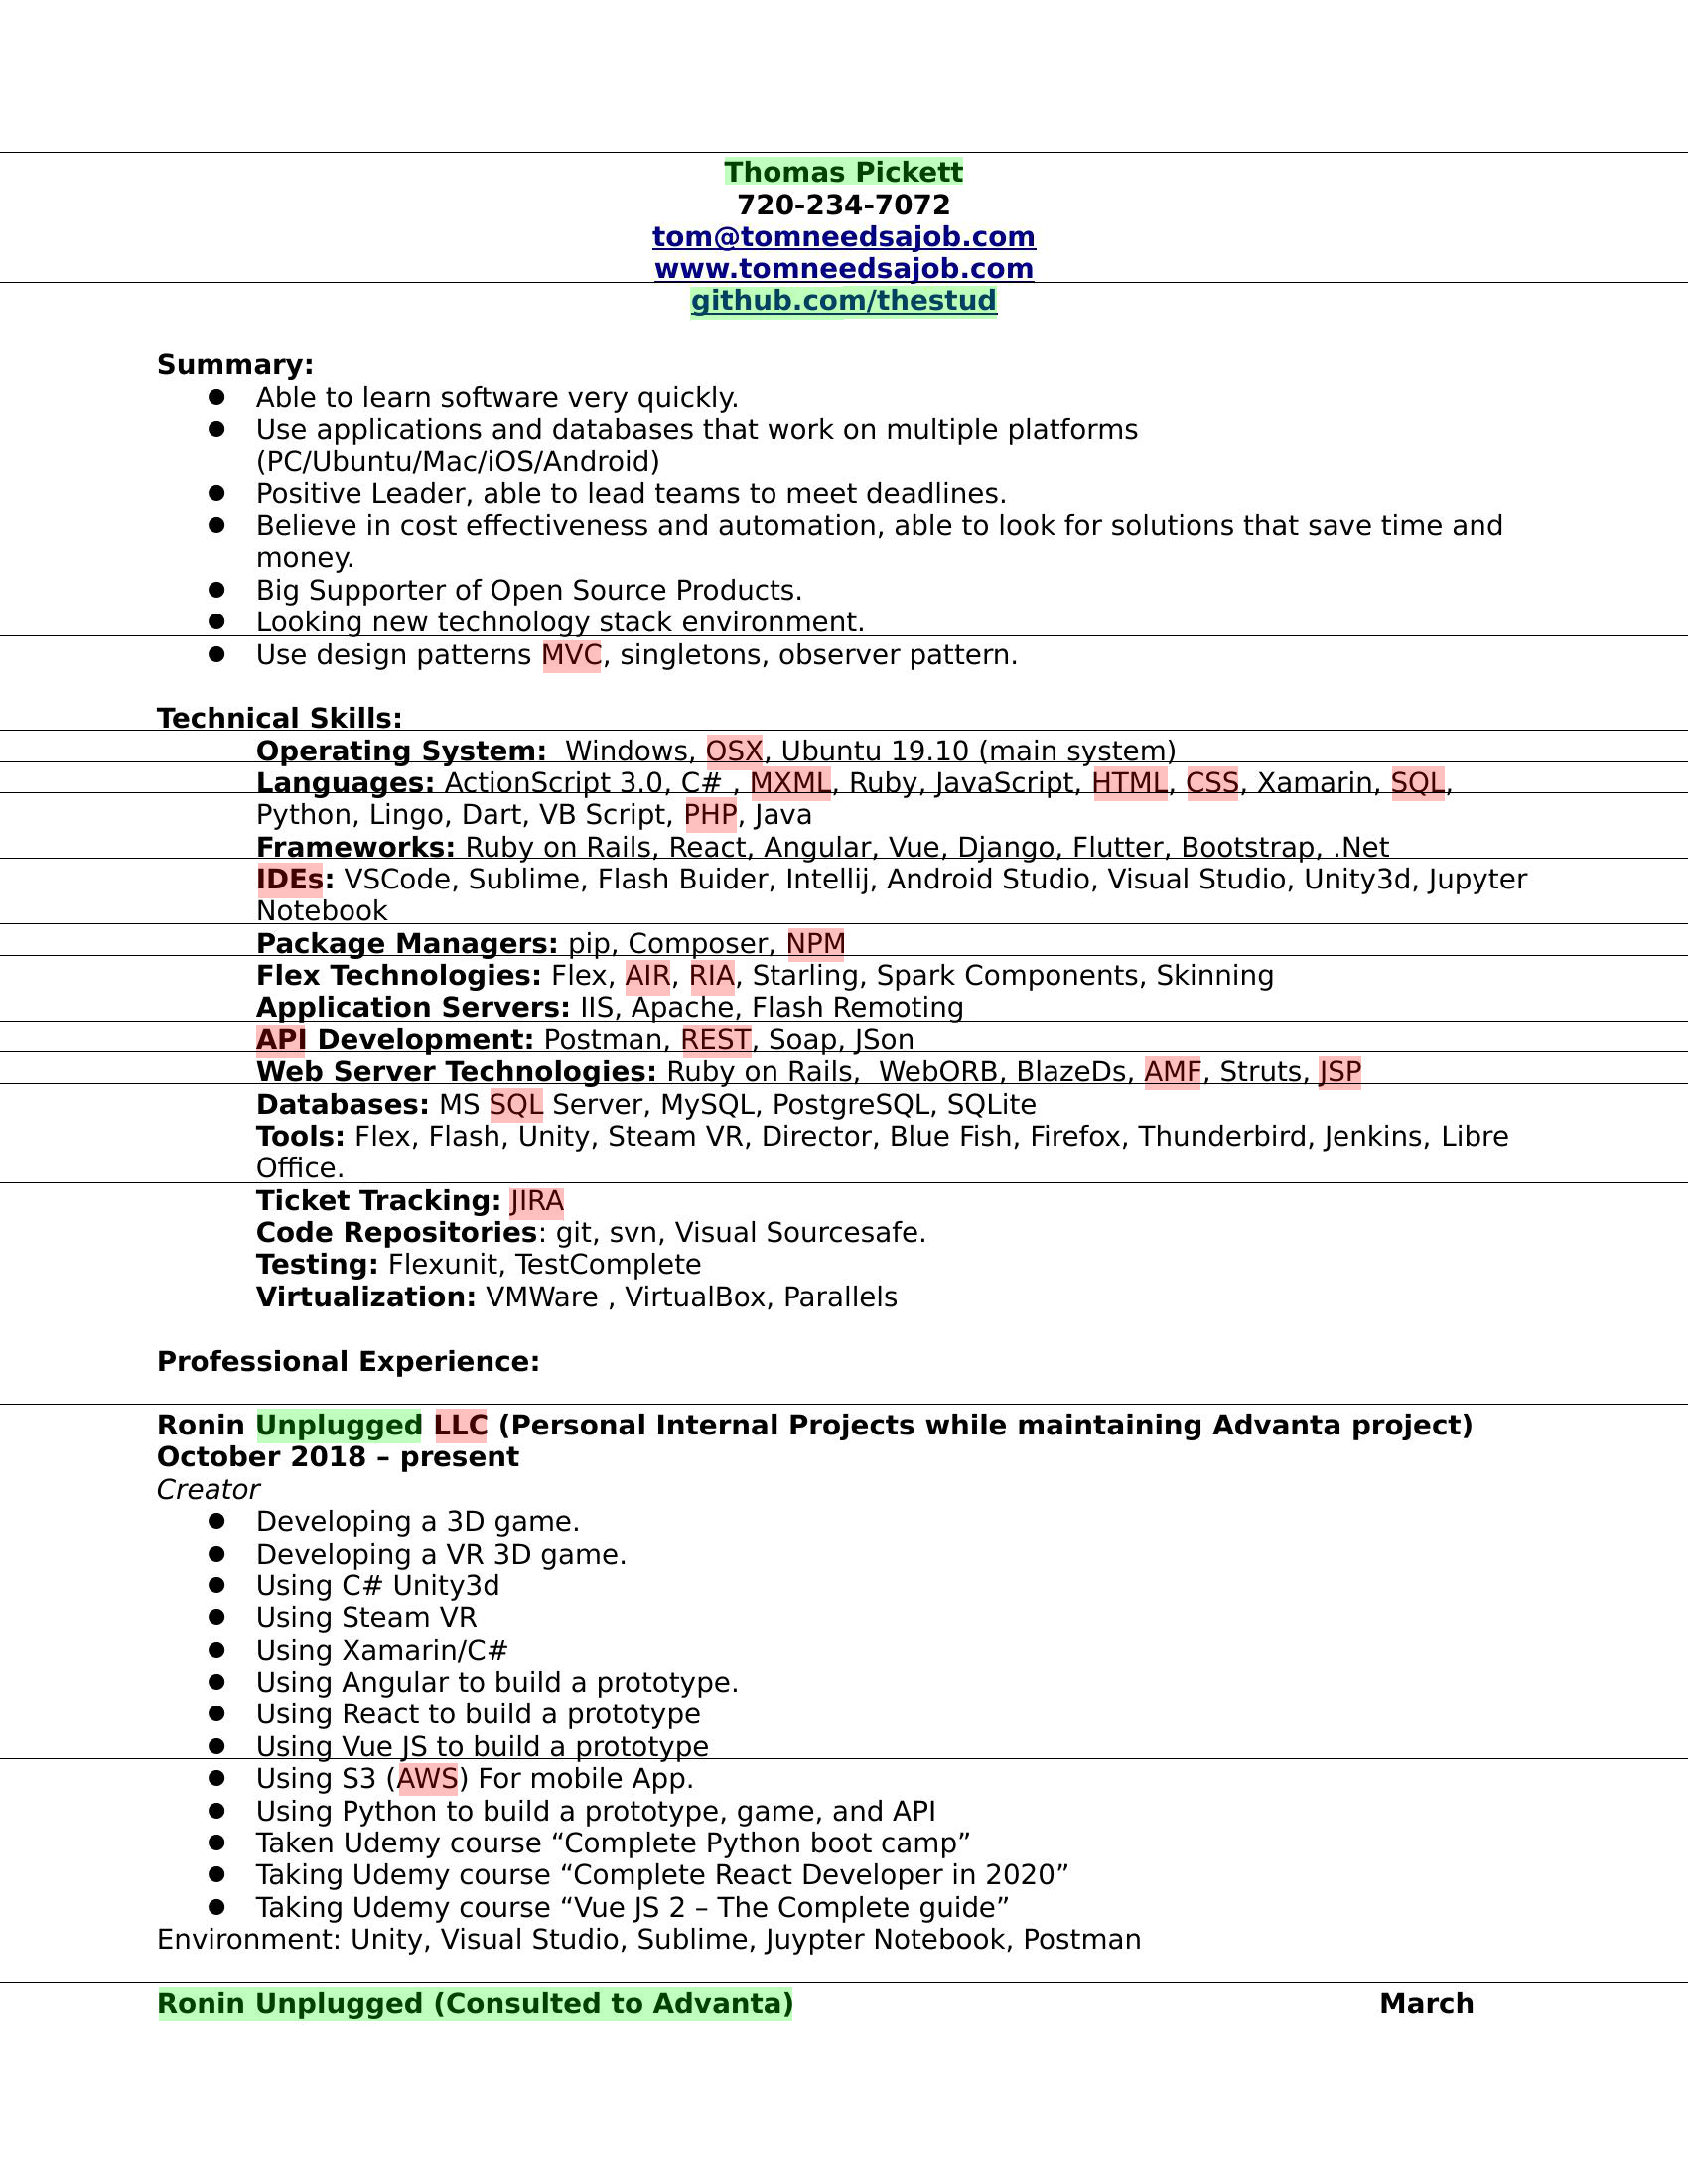

In [75]:
img

In [76]:
oldIMG = img

In [77]:
os.chdir("/Users/kunal/Documents/VdartResumeProject/VisionAPi/ErosionSaveImg")

In [78]:
img.save(os.path.basename(imagePath)[:-4] + "1.jpg")

In [79]:
#===============TOTAL OF 10 MIN OR MORE TO RUN=======================

# Create Data Test 2

## Create Data to be used later 

In [80]:
boxesForCharsGoodMedian = []
boxesForCharsbadMedian= []
boxesForCharsGoodMean= []
boxesForCharsbadMean= []
boxesForCharsGoodMode= []
boxesForCharsbadMode= []
boxesForCharsGoodOutlier= []
boxesForCharsbadOutlier= []

In [81]:
dfthingtester = []
BlockNum = 1
ParaNum = 1
WordNum = 1
for page in document.pages:
    for block in page.blocks:
        for paragraph in block.paragraphs:
            for word in paragraph.words:
                wordTextRunning = ""
                for symbol in word.symbols:
                    wordTextRunning+=symbol.text
                    cropPoints = convertBoundBoxtodiagonalRectangual(symbol.bounding_box)
                    im = Image.open(imagePath).convert("RGBA")
                    im_crop = im.crop(cropPoints)
                    opencvImage = cv2.cvtColor(np.array(im_crop), cv2.COLOR_RGB2BGR)
                    img_reverted= cv2.bitwise_not(opencvImage)
                    new_img = img_reverted / 255.0 
                    #croppedTopBottomImg = cutTopandBottomBlackRowsFunction(new_img)
                    newImgOnly01 = convertImgto01OrginalFunction(new_img)
                    croppedTopBottomImgOnly01 = cropTopBottomFrom01Img(newImgOnly01)
                    #display = [new_img,croppedTopBottomImg, newImgOnly01, croppedTopBottomImgOnly01]
                    #displayImg(display)
                    percentAreaConverd = percentAreafromImg(croppedTopBottomImgOnly01)
                    boxUpload = False
                    medianTF = False
                    meanTF = False
                    modeTF = False
                    outlierTF = False                     
                    for charGroup in dfListNew2:
                        if charGroup[0] == symbol.text.strip().lower():    
                            boxUpload = True
                            #----------------------------------------------------
                            if percentAreaConverd >= charGroup[4]:
                                boxesForCharsGoodMedian.append(symbol.bounding_box)
                                medianTF = True
                            else:
                                boxesForCharsbadMedian.append(symbol.bounding_box)
                            #----------------------------------------------------
                            if percentAreaConverd >= charGroup[5]:
                                boxesForCharsGoodMean.append(symbol.bounding_box)
                                meanTF = True
                            else:
                                boxesForCharsbadMean.append(symbol.bounding_box)
                            #----------------------------------------------------
                            if percentAreaConverd >= charGroup[6]:
                                boxesForCharsGoodMode.append(symbol.bounding_box)
                                modeTF = True
                            else:
                                boxesForCharsbadMode.append(symbol.bounding_box)
                            #----------------------------------------------------
                            if percentAreaConverd >= charGroup[7]:
                                boxesForCharsGoodOutlier.append(symbol.bounding_box)
                                outlierTF = True
                            else:
                                boxesForCharsbadOutlier.append(symbol.bounding_box)
                            #----------------------------------------------------
                            #break
                    if not boxUpload:
                        #print("Running Extra -->" + symbol.text)
                        #----------------------------------------------------
                        if percentAreaConverd >= 40:
                            boxesForCharsGoodMedian.append(symbol.bounding_box)
                            medianTF = True
                        else:
                            boxesForCharsbadMedian.append(symbol.bounding_box)
                        #----------------------------------------------------
                        if percentAreaConverd >= 40:
                            boxesForCharsGoodMean.append(symbol.bounding_box)
                            meanTF = True
                        else:
                            boxesForCharsbadMean.append(symbol.bounding_box)
                        #----------------------------------------------------
                        if percentAreaConverd >= 40:
                            boxesForCharsGoodMode.append(symbol.bounding_box)
                            modeTF = True
                        else:
                            boxesForCharsbadMode.append(symbol.bounding_box)
                        #----------------------------------------------------
                        if percentAreaConverd >= 40:
                            boxesForCharsGoodOutlier.append(symbol.bounding_box)
                            outlierTF = True
                        else:
                            boxesForCharsbadOutlier.append(symbol.bounding_box)
                        #----------------------------------------------------\
                    #print(symbol.text + "\t" + str(medianTF) + "\t" + str(meanTF) + "\t" + str(modeTF) +"\t" + 
                    #      str(outlierTF))
                    capital = False
                    if symbol.text.isupper():
                        capital= True
                    
                                        
                    dfthingtester.append([symbol.text, medianTF, meanTF, modeTF, outlierTF, capital, WordNum, ParaNum, 
                                          BlockNum, word.bounding_box, paragraph.bounding_box, block.bounding_box])
                WordNum+=1
            ParaNum+=1
        BlockNum+=1
print("Finished")

Finished


## Functions

In [82]:
def convertBoundBoxtodiagonalRectangual(polygon):
    #print(polygon)
    if (abs(polygon.vertices[0].x - polygon.vertices[3].x)<=1 and 
        abs(polygon.vertices[0].y - polygon.vertices[1].y)<=1 and 
        abs(polygon.vertices[1].x - polygon.vertices[2].x)<=1 and 
        abs(polygon.vertices[2].y - polygon.vertices[3].y)<=1):
        matrixCrop = (min(polygon.vertices[0].x, polygon.vertices[3].x),
                      min(polygon.vertices[0].y, polygon.vertices[1].y),
                      max(polygon.vertices[1].x, polygon.vertices[2].x),
                      max(polygon.vertices[2].y, polygon.vertices[3].y))
    else:
        matrixCrop = (min(polygon.vertices[0].x, polygon.vertices[3].x),
                      min(polygon.vertices[0].y, polygon.vertices[1].y),
                      max(polygon.vertices[1].x, polygon.vertices[2].x),
                      max(polygon.vertices[2].y, polygon.vertices[3].y))
        print("MaybeErrrorWhenConvertingPolygonToRectangle")
        #raise Exception
        #matrixCrop = (0,0,0,0)
    return matrixCrop

In [83]:
def polygonwidthCal(polygon):
    if (abs(polygon.vertices[0].x - polygon.vertices[3].x)<=1 and 
        abs(polygon.vertices[0].y - polygon.vertices[1].y)<=1 and 
        abs(polygon.vertices[1].x - polygon.vertices[2].x)<=1 and 
        abs(polygon.vertices[2].y - polygon.vertices[3].y)<=1):
        end = max(polygon.vertices[1].x, polygon.vertices[2].x)
        start = min(polygon.vertices[0].x, polygon.vertices[3].x)
    if ((end-start)/TOTALWIDTHOFDOCUMENT)*100 > 80:
        return True
    return False

In [84]:
def polygonwidthCalulateOnly(polygon):
    if (abs(polygon.vertices[0].x - polygon.vertices[3].x)<=1 and 
        abs(polygon.vertices[0].y - polygon.vertices[1].y)<=1 and 
        abs(polygon.vertices[1].x - polygon.vertices[2].x)<=1 and 
        abs(polygon.vertices[2].y - polygon.vertices[3].y)<=1):
        end = max(polygon.vertices[1].x, polygon.vertices[2].x)
        start = min(polygon.vertices[0].x, polygon.vertices[3].x)
        return end-start
    else:
        print("MaybeError")
        print(polygon.vertices[1].x, polygon.vertices[2].x)
        end = max(polygon.vertices[1].x, polygon.vertices[2].x)
        start = min(polygon.vertices[0].x, polygon.vertices[3].x)
        return end-start

In [85]:
def calculateWeightForWord(newr):
    if len(newr) == 0:
        return ["", 0, 0, 0]
    returnLst = []
    totalSum = 0
    wordtextrunningsmall = ""
    weight = 0
    for symbol in newr:
        if symbol[0].isalpha():
            if symbol[5] == 1:
                currentValues = symbol[1:5]
                for comb in weights:
                    if comb[0] == currentValues:
                        weight += (comb[1] * capitalWeight)
                        #print(comb, end= ' ')
                        #print(comb[1] * capitalWeight)
            else:
                currentValues = symbol[1:5]
                for comb in weights:
                    if comb[0] == currentValues:
                        weight += comb[1]
                        #print(comb)
        else:
            weight = -1
        totalSum+=symbol[1]+symbol[2]+symbol[3]+symbol[4]
        wordtextrunningsmall+=symbol[0]
    if not wordtextrunningsmall in stop_words:
        returnLst.extend([wordtextrunningsmall, totalSum , weight, len(newr)])
    else:
        returnLst.extend([wordtextrunningsmall, 0, 0, len(newr)])
    #print(wordtextrunningsmall + "--> " + str((totalSum/(len(newr)*4))*100))
    #print((weight/len(newr)*100))
    return returnLst

## Convert to excel and Save

In [86]:
colName = ["Char", "Median", "Mean", "Mode", "Outlier", "Capital", "Word", "Para", "Block", "WordBD", "ParaBD", "BlockBD"]
df=pd.DataFrame(dfthingtester, columns=colName) 

In [87]:
os.chdir(docPath)

In [88]:
writer = ExcelWriter(os.path.basename(imagePath)[:-4] + '4.xlsx')
df.to_excel(writer,'Sheet1')

In [89]:
writer.save()

## Convert array from True/False to 0,1 

In [90]:
dfthingtesterNew01 = []
for i in dfthingtester:
    newRunningLst = []
    for j in i:
        if j == True:
            newRunningLst.append(1)
        elif j == False:
            newRunningLst.append(0)
        else:
            newRunningLst.append(j)
    dfthingtesterNew01.append(newRunningLst)

## Set Weights


**Char(0)-Median(1)-Mean(2)-Mode(3)-Outlier(4)-Capital(5)-Word Count(6)-Paragraph Count(7)-Block Count(8)-WordBD(9)-ParaBD(10)-BlockBD(11)**


|Median|Mean|Mode|Outlier|Weight|
|--|--|--|--|--|
|0|0|0|0|0|
|0|0|1|0|0.1|
|0|0|1|0|0.2|
|0|0|1|1|0.4|
|0|1|0|0|0.1|
|0|1|0|1|0.3|
|0|1|1|0|0.4|
|0|1|1|1|0.75|
|1|0|0|0|0.1|
|1|0|0|1|0.4|
|1|0|1|0|0.7|
|1|0|1|1|1|
|1|1|0|0|0.4|
|1|1|0|1|0.75|
|1|1|1|0|1|
|1|1|1|1|1|



In [91]:
capitalWeight = 0.6 + 1

In [92]:
weights = [[[0, 0, 0, 0],0],
            [[0, 0, 0, 1],0.1],
            [[0, 0, 1, 0],0.2],
            [[0, 0, 1, 1],0.4],
            [[0, 1, 0, 0],0.1], 
            [[0, 1, 0, 1],0.3],
            [[0, 1, 1, 0],0.4],
            [[0, 1, 1, 1],0.75],
            [[1, 0, 0, 0],0.1],
            [[1, 0, 0, 1],0.4],
            [[1, 0, 1, 0],0.7],
            [[1, 0, 1, 1],1],
            [[1, 1, 0, 0],0.4],
            [[1, 1, 0, 1], 0.75],
            [[1, 1, 1, 0],1],
            [[1, 1, 1, 1],1]]

## Convert symbols and group them in words

In [93]:
print("TOTAL WORDS --> " + str(dfthingtesterNew01[-1][6]))

TOTAL WORDS --> 435


In [94]:
runningWord = 1
totalForWord = 0
totalGroups = []
for wordNumE in range(dfthingtesterNew01[-1][6]):
    newr = []
    for letter in dfthingtesterNew01:
        if letter[6] == wordNumE:
            totalForWord+=letter[1]+letter[2]+letter[3]+letter[4]
            newr.append(letter)
    if newr != []:
        totalGroups.append(newr)
        #print(totalForWord)
        #print(letter)

## Old Code

# A NEW SCORE SYSTEM

## Thresholds

In [95]:
# Moved to top of the page
#THRESHOLDFORWORD = 70
#THRESHOLDFORPARA = 70
#CUTOFWORDSTHATARE3ORUNDER = True
#MAXIMUMLENGTHOFWORDSPARA = 20
#TOTALSUMFINALPARATHRESHOLD = 50
#No thresholds for blocks cause not using them

## Running it

In [96]:
runningBlock = 1
runningPara = 1
runningCalculationsPara = []
runningCalculationsBlocks = []
bdingBoxWord = []
bdingBoxPara = []
bdingBoxBlock = []
printingToDisplay = False
if printingToDisplay: print("Calculating if the word/paragraph/block is bold")
for kk in totalGroups:
    tester = calculateWeightForWord(kk)
    if tester[3] > 0: #If not then removed
        if CUTOFWORDSTHATARE3ORUNDER:
            if tester[3] >= 3: #Removes words that are under 3 words long
                if (tester[2]/tester[3])*100 > THRESHOLDFORWORD: #threshold of 70 from the weights tester
                    if polygonwidthCalulateOnly(kk[0][9])/FINALAVGMODEOFCHARS > tester[3]:
                        #print(tester[0], end = "\t\t")
                        #print(round(((tester[2]/tester[3])*100),3))
                        if printingToDisplay: print(tester[0] + "\t-->\t"+ 
                                                    colored(str(round(((tester[2]/tester[3])*100),2)), 'red', attrs=['bold']))
                        #-----------------------------
                        bdingBoxWord.append([kk[0][9], round(((tester[2]/tester[3])*100),2), tester[0]])
                        #--------------------------
        else: #Checking for less than 3 words long
            if (tester[2]/tester[3])*100 > THRESHOLDFORWORD: #threshold of 70 from the weights tester
                if polygonwidthCalulateOnly(kk[0][9])/FINALAVGMODEOFCHARS > tester[3]:
                    #print(tester[0], end = "\t\t")
                    #print(round(((tester[2]/tester[3])*100),3))
                    if printingToDisplay: print(tester[0] + "\t-->\t"+ 
                                                colored(str(round(((tester[2]/tester[3])*100),2)), 'yellow', attrs=['bold']))
                    #-----------------------------
                    bdingBoxWord.append([kk[0][9], tester[3], round(((tester[2]/tester[3])*100),2), tester[0]])
                    #--------------------------
    #print(kk[7])
    if kk[0][7] != runningPara:
        if runningCalculationsPara != []: 
            #NewRun
            # LOOKS LIKE THE CALCULATIONS FOR TOTAL WEIGHTS PARA ARE NOT WORKING
            #totalWeightPara = 0
            #allWordsinPara = ""
            #runningCountYes = 0
            #runningTotal = 0
            #for tempWord in runningCalculationsPara:
            #    totalWeightPara+= (tempWord[2]/tempWord[3])*100
            #    runningCountYes+=tempWord[1]
            #    runningTotal+=(tempWord[3]*4)
            #    allWordsinPara += tempWord[0] + " "
            #print("---------------------------------------")
            #print(allWordsinPara + "  ALL  " + str(totalWeightPara/3))
            #print((runningCountYes/runningTotal)*100)
            #print("-=======================================")
            totalYes = 0
            allWordsinPara = ""
            for tempWord in runningCalculationsPara:
                if (tempWord[2]/tempWord[3])*100 > THRESHOLDFORPARA:
                    totalYes+=1
                allWordsinPara += tempWord[0] + " "
            #greater than 20 words
            finalParaTotalSum = totalYes/len(runningCalculationsPara)*100
            if len(runningCalculationsPara) < MAXIMUMLENGTHOFWORDSPARA and finalParaTotalSum > TOTALSUMFINALPARATHRESHOLD:
                if printingToDisplay: print(str(len(runningCalculationsPara)) + "\t-->\t" + allWordsinPara + "\t-->\t"+ 
                                            colored(str(round(finalParaTotalSum,3)), 'blue', attrs=['bold']))
                #print("===================" + allWordsinPara+ "====================" + str(finalParaTotalSum))
                #-----------------------------
                bdingBoxPara.append([kk[0][10], round(finalParaTotalSum,3), allWordsinPara])
                #--------------------------
        runningCalculationsPara=[]
        runningPara+=1
    else:
        runningCalculationsPara.append(tester)
    if kk[0][8] != runningBlock:
        if runningCalculationsBlocks != []:
            totalYesBlock = 0
            allWordsinBlock = ""
            for tempWordBlk in runningCalculationsBlocks:
                if (tempWordBlk[2]/tempWordBlk[3])*100 > 70:
                    totalYesBlock+=1
                allWordsinBlock += tempWordBlk[0] + " "
            #less than than 20 words
            finalBlkTotalSum = totalYesBlock/len(runningCalculationsBlocks)*100
            if len(runningCalculationsBlocks) < 20 and finalBlkTotalSum > 30:
                if printingToDisplay: print(str(len(runningCalculationsBlocks)) + "\t-->\t" + allWordsinBlock + "\t-->\t"+ 
                                            colored(str(round(finalBlkTotalSum,3)), 'green', attrs=['bold']))
                #print("------------------------" + allWordsinBlock+ "====================" + str(finalBlkTotalSum))
                #-----------------------------
                bdingBoxBlock.append([kk[0][11], round(finalBlkTotalSum,3), allWordsinBlock])
                #--------------------------
        runningCalculationsBlocks=[]
        runningBlock+=1 
    else: 
        runningCalculationsBlocks.append(tester)
    #-------------------------------------------------------------------------------------------------
if printingToDisplay: print("Finished")

MaybeError
494 494


## Draw all boxes NOT PROCESSES

In [100]:
AllMatrixes = []
TINT_COLOR = (0,0,0) 
#colors = [(0,255,0), (0,0,255), (255,0,0)]
TRANSPARENCY = 0.25
OPACITY = int(255 * TRANSPARENCY)
img = Image.open(imagePath)
img = img.convert("RGBA")
overlay = Image.new('RGBA', img.size, TINT_COLOR+(0,))
draw = ImageDraw.Draw(overlay)  # Create a context for drawing things on it.
font = ImageFont.truetype(fontPath, size=20)
#for section in boundBoxAll:
TINT_COLOR = (0,255,0) 
for block in bdingBoxBlock:
    matrix = findMatrix(block[0])
    draw.polygon(matrix, fill=TINT_COLOR+(OPACITY,))
#----------------------------------------------------------------------
TINT_COLOR = (255,0,0) 
for para in bdingBoxPara:
    matrix = findMatrix(para[0])
    AllMatrixes.append(matrix)
    draw.polygon(matrix, fill=TINT_COLOR+(OPACITY,))
#----------------------------------------------------------------------
TINT_COLOR = (0,0,255) 
for word in bdingBoxWord:
    matrix = findMatrix(word[0])
    AllMatrixes.append(matrix)
    draw.polygon(matrix, fill=TINT_COLOR+(OPACITY,))
for wordtxt in bdingBoxWord:
    matrix = findMatrix(wordtxt[0])
    color = 'rgb(0, 0, 0)' # black color
    draw.text((matrix[0][0], matrix[0][1]-20), str(wordtxt[1]), fill=color, font=font)
#----------------------------------------------------------------------
TINT_COLOR = (255,0,255) 
for capitalWord in boundingBoxForLargeCapital:
    matrix = findMatrix(capitalWord[0])
    AllMatrixes.append(matrix)
    draw.polygon(matrix, fill=TINT_COLOR+(OPACITY,))
for capitalWord in boundingBoxForLargeCapital:
    matrix = findMatrix(capitalWord[0])
    color = 'rgb(0, 0, 0)' # black color
    draw.text((matrix[0][0], matrix[0][1]-20), str(capitalWord[1]), fill=color, font=font)
img = Image.alpha_composite(img, overlay)
img = img.convert("RGB") # Remove alpha for saving in jpg format.
#img

# Combining All

In [101]:
def countofEach2Lst(lst):
    counterDict = Counter(lst)
    dictList = [] 
    for key, value in counterDict.items(): 
        temp = [key,value] 
        dictList.append(temp) 
    return dictList

In [102]:
AllMatrixesNew = []
for i in bdingBoxWord:
    AllMatrixesNew.append([findMatrix(i[0]), i[1], i[2], "Word"])
for j in bdingBoxPara:
    AllMatrixesNew.append([findMatrix(j[0]), j[1], j[2], "Para"])
for k in boundingBoxForLargeCapital:
    AllMatrixesNew.append([findMatrix(k[0]), k[1], k[2], "Capital"])
for r in boundingBoxWordSimpleSymbolTest:
    AllMatrixesNew.append([findMatrix(r[0]), r[1], r[2], "SymbolAvg"])

In [103]:
#for i in AllMatrixesNew:
    #print(i)

## Print info

In [104]:
AllMatrixSorted = sorted(AllMatrixesNew,key=lambda l:l[0][0][1], reverse=False)

In [105]:
printer = False
if printer:
    for i in AllMatrixSorted:
        print(i[2] + "\t-->\t" + colored(str(i[1]), 'red', attrs=['bold']), end= "\t\t")
        if i[3] == "Word - Capital":
            print(colored("Word Test 2 and Capital", 'green', attrs=['bold']))
        elif i[3] == "Para - Capital":
            print(colored("Para Test 2 and Capital", 'green', attrs=['bold']))
        elif i[3] == "Word":
            print(colored("Word Test 2", 'green', attrs=['bold']))
        elif i[3] == "Para":
            print(colored("Para Test 2", 'green', attrs=['bold']))
        elif i[3] == "Capital":
            print(colored("Capital", 'green', attrs=['bold']))
        elif i[3] == "SymbolAvg":
            print(colored("Test1", 'green', attrs=['bold']))
        elif i[3] == "Word - SymbolAvg":
            print(colored("Word Test 2 and Test 1", 'green', attrs=['bold']))
        elif i[3] == "Capital - SymbolAvg":
            print(colored("Test 1 and Capital", 'green', attrs=['bold']))
        elif i[3] == "Word - Capital - SymbolAvg":
            print(colored("Word Test 1 and Test 2 and Capital", 'green', attrs=['bold']))
        #elif entityDrawingInfo[2] == "Para - Capital - SymbolAvg":
        #print(i)

## Remove Duplicates

In [106]:
lstofMatrices = []
for i in AllMatrixesNew:
    lstofMatrices.append(i[0])
x = countofEach2Lst(lstofMatrices)

In [107]:
duplicates = []
for matrix, count in x:
    if count > 1:
        duplicates.append(matrix)

In [108]:
matrixesPrintDisplay = []
matrixesforDuplicates = []
for i in AllMatrixesNew:
    if i[0] in duplicates:
        matrixesforDuplicates.append(i)
    else:
        matrixesPrintDisplay.append([i[0], i[1], i[3]])

In [109]:
only2duplicate = []
only3duplicate = []
for matrix, count in x:
    if count== 2:
        only2duplicate.append(matrix)
    elif count == 3:
        only3duplicate.append(matrix)

In [110]:
newDuplicatedtoAddedTemp = []
for i in only2duplicate:
    for j in matrixesforDuplicates:
        if i==j[0]:
            newDuplicatedtoAddedTemp.append(j)

In [111]:
newDuplicatedtoAddedTemp3 = []
for i in only3duplicate:
    for j in matrixesforDuplicates:
        if i==j[0]:
            newDuplicatedtoAddedTemp3.append(j)

In [112]:
DuplicatedtoAddedFINAL = []
for x in range(0, len(newDuplicatedtoAddedTemp),2):
    #print(newDuplicatedtoAddedTemp[x][0])
    strScores = str(newDuplicatedtoAddedTemp[x][1]) + " - " + str(newDuplicatedtoAddedTemp[x+1][1])
    strtext = str(newDuplicatedtoAddedTemp[x][3]) + " - " + str(newDuplicatedtoAddedTemp[x+1][3])
    DuplicatedtoAddedFINAL.append([newDuplicatedtoAddedTemp[x][0], strScores , strtext])

In [113]:
DuplicatedtoAddedFINAL3 = []
for x in range(0, len(newDuplicatedtoAddedTemp3),3):
    #print(newDuplicatedtoAddedTemp[x][0])
    strScores = str(newDuplicatedtoAddedTemp3[x][1]) + " - " + str(newDuplicatedtoAddedTemp3[x+1][1]) + " - " + str(newDuplicatedtoAddedTemp3[x+2][1])
    strtext = str(newDuplicatedtoAddedTemp3[x][3]) + " - " + str(newDuplicatedtoAddedTemp3[x+1][3]) + " - " + str(newDuplicatedtoAddedTemp3[x+2][3])
    DuplicatedtoAddedFINAL3.append([newDuplicatedtoAddedTemp3[x][0], strScores , strtext])

In [114]:
displayINFO = DuplicatedtoAddedFINAL + matrixesPrintDisplay + DuplicatedtoAddedFINAL3

In [115]:
#for i in displayINFO:
    #print(i)

## Display All (NO)

In [116]:
TRANSPARENCY = 0.25
OPACITY = int(255 * TRANSPARENCY)
img = Image.open(imagePath)
img = img.convert("RGBA")
overlay = Image.new('RGBA', img.size, TINT_COLOR+(0,))
draw = ImageDraw.Draw(overlay)  # Create a context for drawing things on it.
for entityDrawingInfo in displayINFO:
    if entityDrawingInfo[2] == "Word - Capital":
        TINT_COLOR = (255,0,0) 
    elif entityDrawingInfo[2] == "Para - Capital":
        TINT_COLOR = (0,255,0)
    elif entityDrawingInfo[2] == "Word":
        TINT_COLOR = (0,0,255) 
    elif entityDrawingInfo[2] == "Para":
        TINT_COLOR = (255,0,255) 
    elif entityDrawingInfo[2] == "Capital":
        TINT_COLOR = (255,255,0) 
    elif entityDrawingInfo[2] == "SymbolAvg":
        TINT_COLOR = (0,255,255) 
    elif entityDrawingInfo[2] == "Word - SymbolAvg":
        TINT_COLOR = (138, 28, 163) 
    elif entityDrawingInfo[2] == "Capital - SymbolAvg":
        TINT_COLOR = (255, 166, 0) 
    elif entityDrawingInfo[2] == "Word - Capital - SymbolAvg":
        TINT_COLOR = (159, 227, 113) 
    elif entityDrawingInfo[2] == "Para - Capital - SymbolAvg":
        TINT_COLOR = (113, 174, 227) 
    else:
        print(entityDrawingInfo[2])
        raise Exception("SomethingWentWrong")
    draw.polygon(entityDrawingInfo[0], fill=TINT_COLOR+(OPACITY,)) 
    color = 'rgb(0, 0, 0)' # black color
    draw.text((entityDrawingInfo[0][0][0], entityDrawingInfo[0][0][1]-20), str(entityDrawingInfo[1]), fill=color, font=font)
img = Image.alpha_composite(img, overlay)
img = img.convert("RGB") # Remove alpha for saving in jpg format.
#img

## Display Without Para(FINAL)

In [117]:
displayINFOnotPara = []
for i in displayINFO:
    if i[2] != "Para":
        displayINFOnotPara.append(i)

In [118]:
TRANSPARENCY = 0.25
OPACITY = int(255 * TRANSPARENCY)
img = Image.open(imagePath)
img = img.convert("RGBA")
overlay = Image.new('RGBA', img.size, TINT_COLOR+(0,))
draw = ImageDraw.Draw(overlay)  # Create a context for drawing things on it.
for entityDrawingInfo in displayINFOnotPara:
    if entityDrawingInfo[2] == "Word - Capital":
        TINT_COLOR = (255,0,0) 
    elif entityDrawingInfo[2] == "Para - Capital":
        TINT_COLOR = (0,255,0)
    elif entityDrawingInfo[2] == "Word":
        TINT_COLOR = (0,0,255) 
    elif entityDrawingInfo[2] == "Para":
        TINT_COLOR = (255,0,255) 
    elif entityDrawingInfo[2] == "Capital":
        TINT_COLOR = (255,255,0) 
    elif entityDrawingInfo[2] == "SymbolAvg":
        TINT_COLOR = (0,255,255) 
    elif entityDrawingInfo[2] == "Word - SymbolAvg":
        TINT_COLOR = (138, 28, 163) 
    elif entityDrawingInfo[2] == "Capital - SymbolAvg":
        TINT_COLOR = (255, 166, 0) 
    elif entityDrawingInfo[2] == "Word - Capital - SymbolAvg":
        TINT_COLOR = (159, 227, 113) 
    elif entityDrawingInfo[2] == "Para - Capital - SymbolAvg":
        TINT_COLOR = (113, 174, 227) 
    else:
        print(entityDrawingInfo[2])
        raise Exception("SomethingWentWrong")
    draw.polygon(entityDrawingInfo[0], fill=TINT_COLOR+(OPACITY,)) 
    color = 'rgb(0, 0, 0)' # black color
    draw.text((entityDrawingInfo[0][0][0], entityDrawingInfo[0][0][1]-20), str(entityDrawingInfo[1]), fill=color, font=font)
thresholdTxt = ("Avg Symbols Word " + str(THRESHOLDSYMBOLMEANTESTWORD) + "  Avg Word Score " + 
                str(THRESHOLDPARAGROUPSYMWORD) + "    " + str(THRESHOLDFORWORD) + "  Weight Para" + 
                str(THRESHOLDFORPARA) + " Remove words len(3) or less" + str(CUTOFWORDSTHATARE3ORUNDER) + 
                "  Max Words in Para" + str(MAXIMUMLENGTHOFWORDSPARA) + "  Final Sum Para" + 
                str(TOTALSUMFINALPARATHRESHOLD))
draw.rectangle(((0,0),(390, 140)), fill=(255,255,255), outline = "black")
color = 'rgb(0, 0, 0)'
draw.text((0,0), "1-Avg Symbols Score for Word", fill=color, font=font)
draw.text((0,20), "1-Avg Para Score", fill=color, font=font)
draw.text((0,40), "2-Weight Score for Word", fill=color, font=font)
draw.text((0,60), "2-Weight Score for Para", fill=color, font=font)
draw.text((0,80), "2-3 Words or Less", fill=color, font=font)
draw.text((0,100), "2-Max Words in Para", fill=color, font=font)
draw.text((0,120), "2-Avg Weight Score for Para", fill=color, font=font)
color = 'rgb(255, 0, 0)'
draw.text((350,0), str(THRESHOLDSYMBOLMEANTESTWORD), fill=color, font=font)
draw.text((350,20), str(THRESHOLDPARAGROUPSYMWORD), fill=color, font=font)
draw.text((350,40), str(THRESHOLDFORWORD), fill=color, font=font)
draw.text((350,60), str(THRESHOLDFORPARA), fill=color, font=font)
draw.text((350,80), str(CUTOFWORDSTHATARE3ORUNDER)[0], fill=color, font=font)
draw.text((350,100), str(MAXIMUMLENGTHOFWORDSPARA) , fill=color, font=font)
draw.text((350,120), str(TOTALSUMFINALPARATHRESHOLD), fill=color, font=font)
img = Image.alpha_composite(img, overlay)
img = img.convert("RGB") # Remove alpha for saving in jpg format.
#img

# IMG -- x

In [140]:
import datetime
x = datetime.datetime.now()

In [119]:
img # oldIMG for old one
os.chdir("/Users/kunal/Documents/VdartResumeProject/VisionAPi/ErosionSaveImg")
img.save(os.path.basename(imagePath)[:-4] + str(x)[5:10]+"_"+str(x)[11:16] "FINAL.jpg")

In [145]:
img.size

(1700, 2200)

Add code for lines and processing more and start to run all
Add code for average at each y value

In [ ]:
------------------------------------------------

# Lines

## Removing Duplicates --> Really needed?

In [ ]:
"""alypoints = []
for singleM in AllMatrixesNew:
    alypoints.append(singleM[0][1])
alypoints.sort()
alypointsRemoved =set(alypoints)
numofEach = Counter(alypoints)"""

## Draw

In [ ]:
TINT_COLOR = (0,0,0) 
#colors = [(0,255,0), (0,0,255), (255,0,0)]
TRANSPARENCY = 0.25
OPACITY = int(255 * TRANSPARENCY)
img = Image.open(imagePath)
img = img.convert("RGBA")
overlay = Image.new('RGBA', img.size, TINT_COLOR+(0,))
draw = ImageDraw.Draw(overlay)  # Create a context for drawing things on it.
x, y= img.size
TINT_COLOR = (0,255,0) 
for para in bdingBoxPara:
    matrix = findMatrix(para)
    AllMatrixes.append(matrix)
    draw.polygon(matrix, fill=TINT_COLOR+(OPACITY,))
TINT_COLOR = (0,0,255) 
for word in bdingBoxWord:
    # Add for things that are not meeting the width requirment
    if polygonwidthCalulateOnly(word[0])/FINALAVGMODEOFCHARS > word[1]-0.5:
        matrix = findMatrix(word[0])
        AllMatrixes.append(matrix)
        draw.polygon(matrix, fill=TINT_COLOR+(OPACITY,))
TINT_COLOR = (255,0,0) 
for para in boundingBoxForLargeCapital:
    matrix = findMatrix(para)
    draw.polygon(matrix, fill=TINT_COLOR+(OPACITY,))
for yPos in alypoints:
    shape = [(0, yPos-5), (x, yPos-5)]
    draw.line(shape, fill ="black", width = 1) 
img = Image.alpha_composite(img, overlay)
img = img.convert("RGB") # Remove alpha for saving in jpg format.
img

In [ ]:
=====================================================

# Steps Info

In [ ]:
"""
Go by words 
1) Extract word
2) For each symbol in word convert image to array (RGB removed) 0-1 range of each pixel
3) New array with only 0 and 1 (remove RGB)
4) Find percent of area filled by character
5) For each character in entire document group it by type of symbol (a,b,c,d..etc)
6) Find average area taken in by symbol
7) Compare that to area of testing symbol in step 4
8) Count in the number of characters that was taken in when finding average area of cymbol (step 6)
9) Make decision if character is bold or not
10) Look at entire word and see if average is a bold word
11) Look at entire paragraphs to check if paragraph is bold
12) Highlight everything
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
http://mile.ee.iisc.ac.in/publications/softCopy/DocumentAnalysis/Sai_NCVPRIPG2013.pdf
https://homepages.inf.ed.ac.uk/rbf/HIPR2/erode.htm
"""

# Dates

In [ ]:
TINT_COLOR = (0,0,0) 
#colors = [(0,255,0), (0,0,255), (255,0,0)]
TRANSPARENCY = 0.25
OPACITY = int(255 * TRANSPARENCY)
img = Image.open(imagePath)
img = img.convert("RGBA")
overlay = Image.new('RGBA', img.size, TINT_COLOR+(0,))
draw = ImageDraw.Draw(overlay)  # Create a context for drawing things on it.
x, y= img.size
font = ImageFont.truetype(fontPath, size=20)
TINT_COLOR = (0,255,0) 
for para in bdingBoxPara:
    matrix = findMatrix(para)
    AllMatrixes.append(matrix)
    draw.polygon(matrix, fill=TINT_COLOR+(OPACITY,))
TINT_COLOR = (0,0,255) 
#for word in bdingBoxWord:
    # Add for things that are not meeting the width requirment
for matrix in AllMatrixesNew:
    draw.polygon(matrix, fill=TINT_COLOR+(OPACITY,))
TINT_COLOR = (255,0,0) 
for para in boundingBoxForLargeCapital:
    matrix = findMatrix(para)
    draw.polygon(matrix, fill=TINT_COLOR+(OPACITY,))
for yPos in alypointsRemoved:
    shape = [(0, yPos-5), (x, yPos-5)]
    
    draw.line(shape, fill ="black", width = 1) 
for yPos in alypointsRemoved:
    textLocation = (0, yPos-20)
    (x, y) = textLocation
    color = 'rgb(0, 0, 0)' # black color
    draw.text((x, y), str(yPos), fill=color, font=font)
img = Image.alpha_composite(img, overlay)
img = img.convert("RGB") # Remove alpha for saving in jpg format.
img

In [ ]:
fffffff = AllMatrixesNew 

In [ ]:
for num in AllMatrixesNew:
    if num[0][1] == 915:
        print(num)

In [ ]:
alypoints = []
for singleM in set(AllMatrixesNew):
    alypoints.append(singleM[0][1])
alypoints.sort()
alypointsRemoved =set(alypoints)
numofEach = Counter(alypoints)

In [ ]:
numofEachyPosLst = []
for i,j in numofEach.items(): 
    numofEachyPosLst.append([i,j]) 

In [ ]:
tempLst = []
for i in numofEachyPosLst:
    #print(i)
    if i[1] != 1:
        tempLst.append(i[0])

In [ ]:
tempLst

In [ ]:
TINT_COLOR = (0,0,0) 
#colors = [(0,255,0), (0,0,255), (255,0,0)]
TRANSPARENCY = 0.25
OPACITY = int(255 * TRANSPARENCY)
img = Image.open(imagePath)
img = img.convert("RGBA")
overlay = Image.new('RGBA', img.size, TINT_COLOR+(0,))
draw = ImageDraw.Draw(overlay)  # Create a context for drawing things on it.
x, y= img.size
font = ImageFont.truetype(fontPath, size=20)
TINT_COLOR = (0,255,0) 
for para in bdingBoxPara:
    matrix = findMatrix(para)
    AllMatrixes.append(matrix)
    draw.polygon(matrix, fill=TINT_COLOR+(OPACITY,))
TINT_COLOR = (0,0,255) 
#for word in bdingBoxWord:
    # Add for things that are not meeting the width requirment
for matrix in AllMatrixesNew:
    draw.polygon(matrix, fill=TINT_COLOR+(OPACITY,))
TINT_COLOR = (255,0,0) 
for para in boundingBoxForLargeCapital:
    matrix = findMatrix(para)
    draw.polygon(matrix, fill=TINT_COLOR+(OPACITY,))
for yPos in tempLst:
    shape = [(0, yPos-5), (x, yPos-5)]
    draw.line(shape, fill ="black", width = 1) 
for yPos in tempLst:
    textLocation = (0, yPos-20)
    (x, y) = textLocation
    color = 'rgb(0, 0, 0)' # black color
    draw.text((x, y), str(yPos), fill=color, font=font)
img = Image.alpha_composite(img, overlay)
img = img.convert("RGB") # Remove alpha for saving in jpg format.
img

In [ ]:
def detectDate(text):
    doc = nlp(text)
    for entity in doc.ents:
        if entity.label_=="DATE":
            return True
    return False
def detectDateWord(text):
    doc = nlp(text)
    for entity in doc.ents:
        if entity.label_=="DATE":
            return entity.text.split()
    return []

In [ ]:
dateBoxes = []
for page in document.pages:
    for block in page.blocks:
        for paragraph in block.paragraphs:
            paraRun = ""
            for word in paragraph.words:
                wordRun = ""
                for symbol in word.symbols:
                    wordRun+=symbol.text
                if detectDate(wordRun.strip()):
                    dateBoxes.append(word.bounding_box)

In [ ]:
# go through all the things and create a list with all the dates and titles 
# using this we can create a timeline


In [ ]:
import dateutil.parser as dparser

In [ ]:


color = (0,0,255)
TINT_COLOR = (0,0,0) 
TRANSPARENCY = 0.25
OPACITY = int(255 * TRANSPARENCY)
img = Image.open(imagePath)
img = img.convert("RGBA")
overlay = Image.new('RGBA', img.size, TINT_COLOR+(0,))
draw = ImageDraw.Draw(overlay)  # Create a context for drawing things on it.
font = ImageFont.truetype(fontPath, size=20)
#for section in boundBoxAll:
TINT_COLOR = color
for para in dateBoxes:
    matrix = findMatrix(para)
    textLocation = (matrix[0][0], matrix[0][1]-20)
    (x, y) = textLocation
    message = "Date"
    color = 'rgb(0, 0, 0)' # black color
    draw.text((x, y), message, fill=color, font=font)
    draw.polygon(matrix, fill=TINT_COLOR+(OPACITY,))
for para in dateBoxes:
    matrix = findMatrix(para)
    textLocation = (matrix[0][0], matrix[0][1]-20)
    (x, y) = textLocation
    message = "Date"
    color = 'rgb(0, 0, 0)' # black color
    draw.text((x, y), message, fill=color, font=font)
    draw.polygon(matrix, fill=TINT_COLOR+(OPACITY,))
img = Image.alpha_composite(img, overlay)
img = img.convert("RGB") # Remove alpha for saving in jpg format.

# Entity Extraction --> Work on after Dates

In [ ]:
def extractMajorEntities(text_content, salienceScoreThres):
    keyDIR = nlpAutoAPIPath # JSON path with the crediatials 
    credentials = service_account.Credentials.from_service_account_file(keyDIR) # same as before api credentials
    client = language_v1.LanguageServiceClient(credentials=credentials)  # language client 
    type_ = enums.Document.Type.PLAIN_TEXT 
    language = "en" # english text
    document = {"content": text_content, "type": type_, "language": language} #formatting the design of api input -- leave it
    encoding_type = enums.EncodingType.UTF8 # reading the document -- must have 
    response = client.analyze_entities(document, encoding_type=encoding_type) # actual run of the api
    majorValues = []
    for entity in response.entities:  #reading the JSON that was returned by analyze entities
        if entity.salience > salienceScoreThres: #salience score is the importance of the entity compared to the full document
            majorValues.append([entity.name,entity.salience]) # if it is greater than the threshold then save it and return it
    return  majorValues
def extractEntities(text_content):
    keyDIR = nlpAutoAPIPath# JSON path with the crediatials 
    credentials = service_account.Credentials.from_service_account_file(keyDIR) # same as before api credentials
    client = language_v1.LanguageServiceClient(credentials=credentials) # language client
    type_ = enums.Document.Type.PLAIN_TEXT
    language = "en"# english text
    document = {"content": text_content, "type": type_, "language": language}#formatting the design of api input -- leave it
    encoding_type = enums.EncodingType.UTF8# reading the document -- must have 
    response = client.analyze_entities(document, encoding_type=encoding_type) # actual run of the api

In [ ]:
text_content = document.text

In [ ]:
keyDIR = nlpAutoAPIPath # JSON path with the crediatials 
credentials = service_account.Credentials.from_service_account_file(keyDIR) # same as before api credentials
client = language_v1.LanguageServiceClient(credentials=credentials)  # language client 
type_ = enums.Document.Type.PLAIN_TEXT 
language = "en" # english text
document = {"content": text_content, "type": type_, "language": language} #formatting the design of api input -- leave it
encoding_type = enums.EncodingType.UTF8 # reading the document -- must have 
response = client.analyze_entities(document, encoding_type=encoding_type) # actual run of the api

In [ ]:
for entity in response.entities: # loop through json and see all entities
    currentRunningEntity = []
    print(entity.name,end="       -->       ")
    print(enums.Entity.Type(entity.type).name)

In [ ]:
for entity in response.entities:
    for i in entity.mentions:
        print(i.text)
    print("-=------------")

In [ ]:
for entity in response.entities: # loop through json and see all entities
    currentRunningEntity = []
    print(entity.name)
    print(enums.Entity.Type(entity.type).name)
    if enums.Entity.Type(entity.type).name not in nonuseEntities: # check if meta data from entity is important
        #print("Detected " + entity.name + " as " + enums.Entity.Type(entity.type).name)
        currentRunningEntity.append(entity.name)
        currentRunningEntity.append(enums.Entity.Type(entity.type).name)
        allEntitiesExtracted.append(currentRunningEntity) # append it to list 
    else: 
        for mention in entity.mentions:
            if enums.EntityMention.Type(mention.type).name == "PROPER":
                #print("Detected " + mention.text.content + " as " + enums.EntityMention.Type(mention.type).name)
                currentRunningEntity.append(mention.text.content)
                currentRunningEntity.append(enums.EntityMention.Type(mention.type).name)
                allEntitiesExtracted.append(currentRunningEntity) # another check if it entity is important 
                # must see format or return entity to see how this is working 
    #allEntitiesExtracted.append(currentRunningEntity) if currentRunningEntity != [] else print("-")
    #allEntitiesExtracted.append(currentRunningEntity)   

In [ ]:
salienceScoreThres=0.01
majorValues = []
for entity in response.entities:  #reading the JSON that was returned by analyze entities
    if entity.salience > salienceScoreThres: #salience score is the importance of the entity compared to the full document
        majorValues.append([entity.name,entity.salience]) 

In [ ]:
majorValues

# Display all info for each test single

## Median

In [ ]:
TINT_COLOR = (0,0,0) 
#colors = [(0,255,0), (0,0,255), (255,0,0)]
TRANSPARENCY = 0.25
OPACITY = int(255 * TRANSPARENCY)
img = Image.open(imagePath)
img = img.convert("RGBA")
overlay = Image.new('RGBA', img.size, TINT_COLOR+(0,))
draw = ImageDraw.Draw(overlay)  # Create a context for drawing things on it.
#for section in boundBoxAll:
TINT_COLOR = (0,255,0) 
for para in boxesForCharsGoodMedian:
    matrix = findMatrix(para)
    draw.polygon(matrix, fill=TINT_COLOR+(OPACITY,))
TINT_COLOR = (255,0,0) 
for para in boxesForCharsbadMedian:
    matrix = findMatrix(para)
    draw.polygon(matrix, fill=TINT_COLOR+(OPACITY,))
img = Image.alpha_composite(img, overlay)
img = img.convert("RGB") # Remove alpha for saving in jpg format.
img

## Mean

In [ ]:
TINT_COLOR = (0,0,0) 
#colors = [(0,255,0), (0,0,255), (255,0,0)]
TRANSPARENCY = 0.25
OPACITY = int(255 * TRANSPARENCY)
img = Image.open(imagePath)
img = img.convert("RGBA")
overlay = Image.new('RGBA', img.size, TINT_COLOR+(0,))
draw = ImageDraw.Draw(overlay)  # Create a context for drawing things on it.
#for section in boundBoxAll:
TINT_COLOR = (0,255,0) 
for para in boxesForCharsGoodMean:
    matrix = findMatrix(para)
    draw.polygon(matrix, fill=TINT_COLOR+(OPACITY,))
TINT_COLOR = (255,0,0) 
for para in boxesForCharsbadMean:
    matrix = findMatrix(para)
    draw.polygon(matrix, fill=TINT_COLOR+(OPACITY,))
img = Image.alpha_composite(img, overlay)
img = img.convert("RGB") # Remove alpha for saving in jpg format.
img

## Mode

In [ ]:
TINT_COLOR = (0,0,0) 
#colors = [(0,255,0), (0,0,255), (255,0,0)]
TRANSPARENCY = 0.25
OPACITY = int(255 * TRANSPARENCY)
img = Image.open(imagePath)
img = img.convert("RGBA")
overlay = Image.new('RGBA', img.size, TINT_COLOR+(0,))
draw = ImageDraw.Draw(overlay)  # Create a context for drawing things on it.
#for section in boundBoxAll:
TINT_COLOR = (0,255,0) 
for para in boxesForCharsGoodMode:
    matrix = findMatrix(para)
    draw.polygon(matrix, fill=TINT_COLOR+(OPACITY,))
TINT_COLOR = (255,0,0) 
for para in boxesForCharsbadMode:
    matrix = findMatrix(para)
    draw.polygon(matrix, fill=TINT_COLOR+(OPACITY,))
img = Image.alpha_composite(img, overlay)
img = img.convert("RGB") # Remove alpha for saving in jpg format.
img

## Outlier

In [ ]:
TINT_COLOR = (0,0,0) 
#colors = [(0,255,0), (0,0,255), (255,0,0)]
TRANSPARENCY = 0.25
OPACITY = int(255 * TRANSPARENCY)
img = Image.open(imagePath)
img = img.convert("RGBA")
overlay = Image.new('RGBA', img.size, TINT_COLOR+(0,))
draw = ImageDraw.Draw(overlay)  # Create a context for drawing things on it.
#for section in boundBoxAll:
TINT_COLOR = (0,255,0) 
for para in boxesForCharsGoodOutlier:
    matrix = findMatrix(para)
    draw.polygon(matrix, fill=TINT_COLOR+(OPACITY,))
TINT_COLOR = (255,0,0) 
for para in boxesForCharsbadOutlier:
    matrix = findMatrix(para)
    draw.polygon(matrix, fill=TINT_COLOR+(OPACITY,))
img = Image.alpha_composite(img, overlay)
img = img.convert("RGB") # Remove alpha for saving in jpg format.
img